# Micrograd

This notebook contains notes and code from Andrej Karpathy's Micrograd lesson

Micrograd repo is here: https://github.com/karpathy/micrograd

The notes below review the theory. Micrograd illustrates the workings of creating a Multi Layer Perceptron and training it using backpropagation. Micrograd uses scalar values unlike a package like Pytorch which is based on Tensors.

# Derivatives and The Chain Rule

We want to find the derivative $dy/dx$ of the function $y = f(g(x))$. If we write $u = g(x)$, then $dy/dx = df/du * du/dx$

Another way to say this is $y' = f'(g(x)) * g'(x)$

## Why would we care about chain rule?

We do because we can take the output of an expression, say $g$, and if we represent the expression as a tree with intermediate values as parents, then we can use the chain rule and backpropagation to walk up the tree to the inputs and determine the deriviative of the output $g$ from inputs $a$ and $b$. This can be used as the mechanism for training Neural Networks (NNs).

In practice we train using Tensors instead of scalar values, but the principles and maths are the same. In other words we can study a simple scalar engine that works with arou 150 lines of code. Everything else beyond that is scale (ie complex tensors) and optimization (eg parallel processing using vectorized processing).

In [146]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Example Function

Below is a function that we'll use to discuss the derivative

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

We can calculate the value of $f()$ at some arbitrary point, and also plot it over a range to visualize how it varies.

In [5]:
f(3.0)

20.0

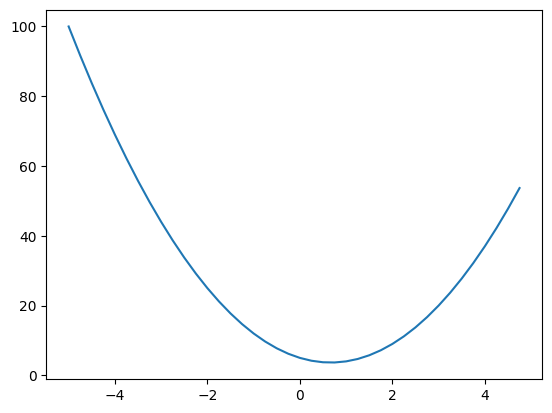

In [9]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

## Derivative of $f(x)$

Let's calculate the derivative at some point x numerically using the formula $f'(x) = (f(x + h) - f(x))/h$ for some small value of $h$.

In [13]:
h = 0.00000001
x = 3.0
(f(x + h) - f(x))/h

14.00000009255109

We see the above is about 14.0, and gets closer to 14.0 exactly the smaller we make $h$ up to some limits of what floating point arithmetic on a computer can do. This jibes with taking the deriviative symbolically as $f'(x) = 6x - 4$ and $f'(3) = 14$ exactly.

## Derivative wrt multiple inputs

Below we have an output d that is the result of 3 inputs, a, b and c. We will want to know the derivatives $d'(a)$, $d'(b)$ and $d'(c)$

In [14]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


To estimate $d'(a)$, use the same derivative forumula where we add a small amount to $a$

In [16]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
d2 = (a+h)*b + c

da = (d2 - d1)/h
print(da)

-3.000000000010772


The result (-3.0) makes sense because $d'(a) = b$ which is -3.0

# Building a Neural Network

The Value class below is used to hold a value in an expression, and also to track the inputs (`Value._prev`) and operation (`Value._op`) that produced the value. Add and multiply operator support is included using the special methods `__add__()` and `__mul__()`.

In [138]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

Below we can construct an expression using Value objects

In [95]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b + c
d.label = 'd'
f = Value(-2.0, label='f')
L = f * d
L.label = 'L'
L

Value(data=-8.0)

In [37]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [38]:
d._op

'+'

In [39]:
d.label

'd'

## Visualizing an Expression based on the Value class

We can visualize the expression $d = a * b + c$ with the following:

In [47]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

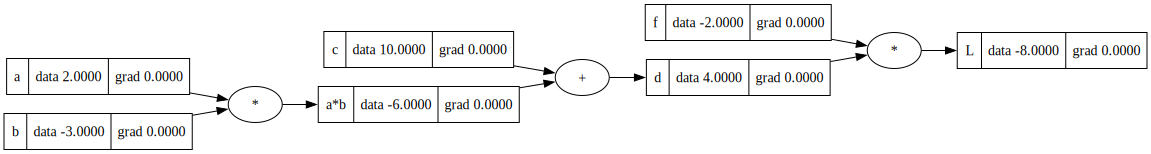

In [63]:
draw_dot(L)

In each of the above nodes we can store in Value.grad the derivative wrt L $dN/dL$. This can be determined using backpropagtion and the chain rule.

To start with: $L = d * f$, so $dL/dd = f$

Similarly, $dL/df = d$

Therefore f.grad = 4.0 and d.grad = -2.0.

Before calculating dL/dc, we can calcuate dd/dc. Since $d = c + (a*b)$, then $dd/dc = 1.0$. In fact when adding we can just propagate the grad of the output back to both inputs, since the "local" derivative $dIn/dOut$ is always 1.0, so by the chain rule $dL/dIn = dIn/dOut * dOut/dL = dOut/dL$.

In [64]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
c.grad = d.grad
a.grad = d.grad * b.data
b.grad = d.grad * a.data

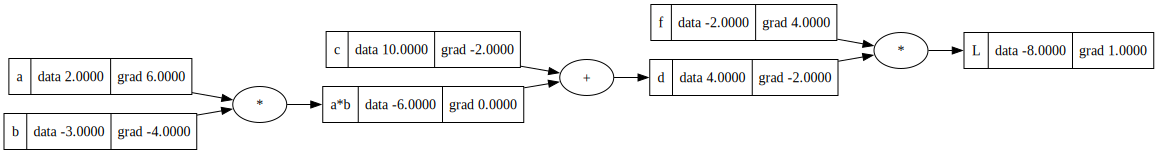

In [65]:
draw_dot(L)

Note that in above we didn't assign a grad value to (a*b), because we don't have a reference to the intermediate value in the formula $d= a*b + c$, but with an automated backpropagation that walks the _prev attribute this can be done (or we could have used d._prev to do this manually.

In [68]:
for i in d._prev:
    print(i.grad)

0.0
-2.0


Instead of an arbitrary mathematical expression we will create a model of a neuron. This model will be very simple compared to an actual neuron which looks like this:

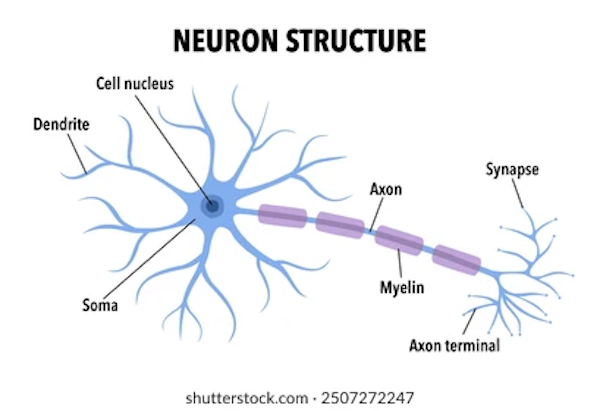

Here is a visualization of an artificial neuron model. There are $m$ inputs $x_i$ which are multiplied by weights $w_ki$ and summed. A bias $b$ is added and the result is fed to an activation function (eg sigmoid or tanh) to produce the output.

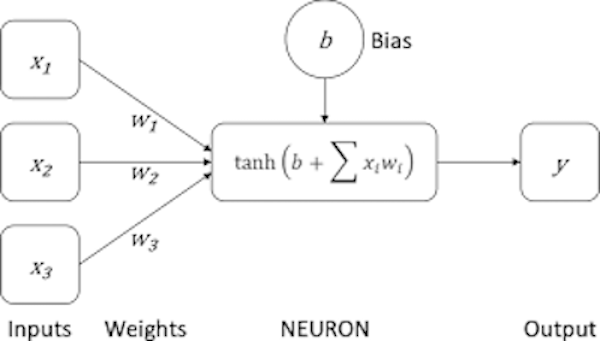

Here we can visualize the tanh function which we will use for the activation function.

More about tanh() here: https://en.wikipedia.org/wiki/Hyperbolic_functions

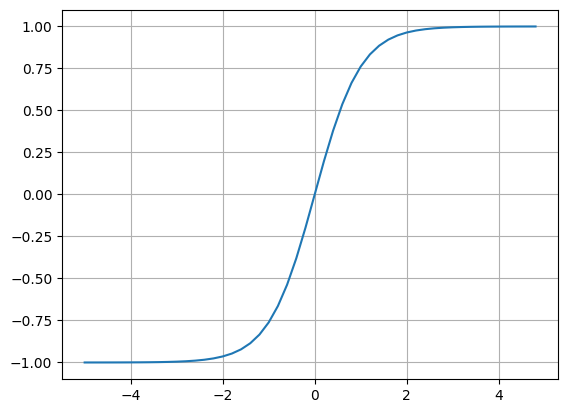

In [69]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

The benefit of the activation function is:
* Introduces non-linearity, allowing the Neuron's output to model more complex results than a simple linear function
* Squashes the input values to a fixed range
* May be used to discard or propagate results (the "activation" part)

The $tanh()$ function is commonly applied to "inner" neurons in a neural network due to its symmetry around zero. Output layers may instead use Sigmoid or ReLU.

Below we can construct a simple Neuron with 2 inputs x1,x2 based on the above model

In [132]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; #x1w1.label = 'x1*w1'
x2w2 = x2*w2; #x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; #x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# output = tanh(n)
o = n.tanh(); o.label = 'o'

Below we can draw the expression and manually assign the grad values manually

In [96]:
# do/do is always just 1.0
o.grad = 1.0

# o = tanh(n)
# do/dn = 1 - tanh(n)^2 = 1 - o^2
n.grad = 1 - o.data ** 2

# For + operation we just propagate grad to the child nodes
# Note that these should be addition += not just assignment
# to handle the case of an expression like b = a + a, where
# the db/da = 2.0 and a.grad = 2.0 * b.grad, but assignment
# would result in just a.grad = b.grad.
b.grad = n.grad
x1w1x2w2.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# For * operation the grad is propagated from the parent
# by multiplying by other.data.
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

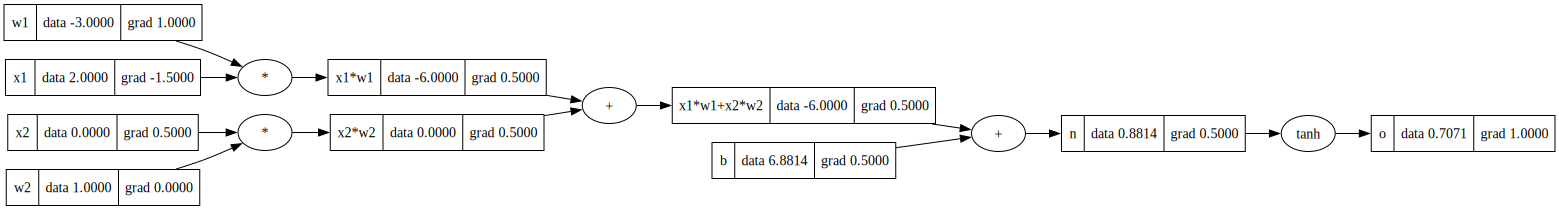

In [134]:
draw_dot(o)

## Automating Gradient Backpropagation

To automate backpropagation the Value operators (eg `__add__()`, `__mul()__`) need to apply the grad assignment rules from above.

These rules cannot be applied immediately in the opeator because at that point we are still building towards the root Value which is the start of the backpropagation, so instead we create a closure and save it in an attribute `_backward` so it can be called on later.

To ensure that each node has its dependencies satisfied before invoking `_backward`, we can do a topological sort on the nodes. Then we can just iterate backwards over the sorted list. We can add a Value method (eg `backward()`) which does the following:

* Perform topological sort starting at root
* Iterate over the result, calling node._backward()

By the way, the Value class is somewhat modeled after PyTorch which for example also implements a `backward()` method.

Topological sort can be done using DFS:
```python
topo = []
visited = set()

def visit(v):
    if v in visited:
        return
    for child in v._prev:
        visit(child)
    visited.add(v)
    topo.insert(0, v)
```

With this implementation, calling `visit(root)` will sort the nodes with root at the beginning of the list, which is the correct order for backpropagation.

Calling `o.backward()` on the above Value graph will perform the same grad assignment as the manual assignment above.

In [133]:
o.backward()

## Additional Operators for Value

Suppose we write `x1 * 5`, this is an error because 5 is not type Value. We can handle non-value types as follows:
```python
other = other if isinstance(other, Value) else Value(other)
```

In [119]:
print(x1)
print(x1 * 5.0)
print(x1 + 5.0)

Value(data=2.0)
Value(data=10.0)
Value(data=7.0)


Another case is `5 * x1`, in that case Python expects to use `int.__mul__(n: int)` and in this case n is a Value.

In [117]:
print(5 * x1)
print(5 + x1)

Value(data=10.0)
Value(data=7.0)


Following are some definitions for $\tanh x $:
$$
\tanh x = \frac{\sinh x}{\cosh x} = \frac {e^x - e^{-x}} {e^x + e^{-x}}
= \frac{e^{2x} - 1} {e^{2x} + 1}
$$

If we want to implement the last definition we'll need Value to support `exp()` and `__pow__(n)` methods.

The are added to the definition above. We can now calculate the same Nuron expression using the exponent definition.

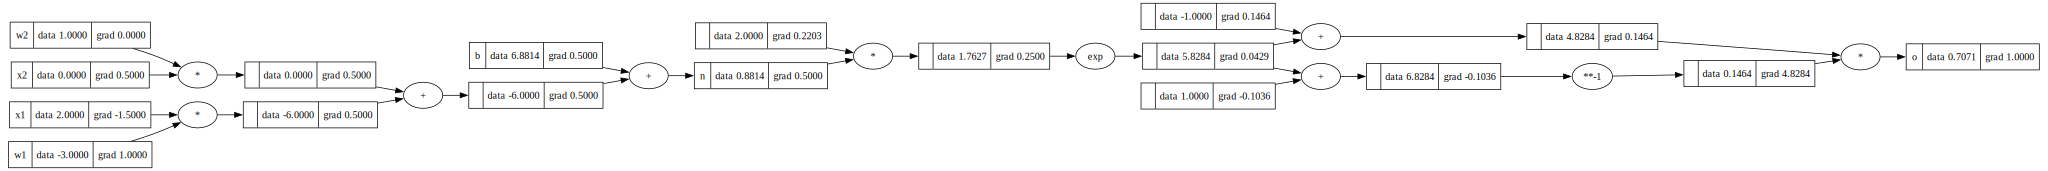

In [137]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1;
x2w2 = x2*w2;
x1w1x2w2 = x1w1 + x2w2;
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

## Pytorch Example

The Value class is modeled after Pytorch Tensor class, but the Value class only supports scalar values.

Below is an example of similar operations using Tensor.

In [139]:
import torch

In [140]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Note that the values for x1,w1 and x2,w2 match those calculated above.

## Neuron Class

So far we wrote out a neuron structure as an expression, eg $$\tanh (b + \sum_{i=1}^{n}{x_i * w_i})$$

Now we can define a class to encapsulate this expression.

In [148]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]


In the above class, the number of inputs is the value `nin` in the constructor. For each input a weight is constructed as a Value with a random value in range -1 to 1, and also the same for the bias `b`.

The `__call__()` method allows to invoke the Neuron instance as a function and pass a list `x` containing the input values. This returns the value of the expression above.

The `parameters()` method returns a list of the tunable parameters of the Neuron (the weights and bias).

## Layer Class

A neural network is composed from layers or neurons. The dimensions are `nin` which is the inputs per neuron, and `nout` which is the number of outputs, ie the number of neurons since each neuron has one output.

In [149]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


## MLP Class

MLP constructs a multi-layer perceptron. This is a feed-forward NN that may be trained using backpropagation. The dimensions are `nin` which is the number of inputs per neuron at the first layer, and there is a list `nouts` which are the outputs at each layer. The length of `nouts` specifies the number of layers. The number of outputs at one layer equals the number of inputs at the next layer.

In [150]:
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


## Example MLP

Below we init an MLP with input vector `x`. The MLP has 3 layers, the middle "hidden" layer has 4 neurons.

In [155]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.23955451923704238)

Above, the output is basically random value based on some input vector. Instead, let's give some sample inputs `xs` and outputs `ys` expected for the given inputs. We'll use the gradient descent to tune the MLP's weights to give the output.

In [156]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


Below is the training loop. For each iteration we calculate a "loss" which is a measure of the distance from the desired result to the predicted one. We adjust each parameter based on the parameter's gradient in order to reduce the loss value. Note that loss itself is a Value object with the NN as the predecessor, and the gradients are all based on dp/dL (the derivative of that parameter wrt to loss).

In [157]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)


0 6.1353987940520085
1 4.12828955339113
2 2.81273559930571
3 1.4667065660397234
4 1.5976275630096635
5 0.31540341508514397
6 0.016147647721274125
7 0.01490976413947288
8 0.01388674315461549
9 0.013023796261861394
10 0.012283673548440784
11 0.011640100006640834
12 0.011073971571506807
13 0.01057104005874263
14 0.010120445891265616
15 0.009713755736423312
16 0.009344312507937137
17 0.009006785031215627
18 0.00869684900858577
19 0.008410956506618293


In [158]:
ypred

[Value(data=0.9558054619355939),
 Value(data=-0.966151100660262),
 Value(data=-0.963226621263476),
 Value(data=0.9370732970696819)]

After the training loop, the parameters have been adjusted so that loss is very small, and the resultant `ypred` is very close to the desired targets.